In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import utils

In [2]:
WINDOW_SIZE = 1
BATCH_SIZE = 32
LABEL_NAME = 'T (degC)'

In [3]:
df_train, df_val, df_test = utils.load_data()
print(f"df_train.shape = {df_train.shape}, df_val.shape = {df_val.shape}, df_test.shape = {df_test.shape}")
df_train.head()

df_train.shape = (49063, 19), df_val.shape = (14018, 19), df_test.shape = (7010, 19)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,-1.366064,-0.366026,-0.069373,1.427981
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,-1.414249,0.000015,-0.068349,1.427977
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,-1.366064,0.366057,-0.067326,1.427971
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,-1.224793,0.707153,-0.066303,1.427965
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,-1.000062,1.000060,-0.065280,1.427958


In [4]:
label_idx = list(df_train.columns).index(LABEL_NAME)

In [5]:
def build_dataset(df_data, window_size, batch_size, label_idx=None, shuffle=True):
    data = np.array(df_data, dtype=np.float32)
    ds = keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size + 1,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    if label_idx is not None:
        ds = ds.map(lambda batched_window: (batched_window[:, :-1, :], batched_window[:, -1:, label_idx:label_idx+1]))
    else:
        ds = ds.map(lambda batched_window: (batched_window[:, :-1, :], batched_window[:, -1:, :]))
    return ds

In [6]:
train_ds = build_dataset(df_train, WINDOW_SIZE, BATCH_SIZE, label_idx)
val_ds = build_dataset(df_val, WINDOW_SIZE, BATCH_SIZE, label_idx)

In [7]:
model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=1)
])

model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=[tf.metrics.MeanAbsoluteError()]
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

history = model.fit(
    train_ds, 
    epochs=20,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/20
1534/1534 [==============================] - 2s 2ms/step - loss: 0.0123 - mean_absolute_error: 0.0767 - val_loss: 0.0111 - val_mean_absolute_error: 0.0777
Epoch 2/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0078 - mean_absolute_error: 0.0637 - val_loss: 0.0074 - val_mean_absolute_error: 0.0628
Epoch 3/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0074 - mean_absolute_error: 0.0621 - val_loss: 0.0073 - val_mean_absolute_error: 0.0618
Epoch 4/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0607 - val_loss: 0.0072 - val_mean_absolute_error: 0.0614
Epoch 5/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0599 - val_loss: 0.0077 - val_mean_absolute_error: 0.0653
Epoch 6/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0589 - val_loss: 0.0067 - val_mean_absolute_error: 0.0586
Epoc

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 64)          1280      
_________________________________________________________________
dense_1 (Dense)              (None, None, 64)          4160      
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           65        
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________


In [32]:
forecast_period = range(24)
actual = []
forecasts = []

for i in forecast_period:
    new_data = df_val.iloc[i].to_numpy()
    new_data = np.expand_dims(new_data, (0, 1))
    forecast = model.predict(new_data)
    forecast = tf.squeeze(forecast).numpy()
    forecasts.append(forecast)
    actual.append(df_val.iloc[i + 1][LABEL_NAME])

In [33]:
utils.evaluate(actual, forecasts)

mse = 0.0063, mae = 0.0627


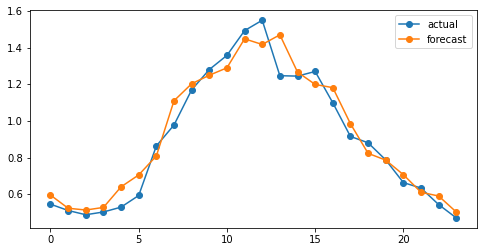

In [34]:
utils.plot_result(actual, forecasts)